In [59]:
track = 'https://envirocar.org/api/stable/tracks/63948bc3ad53a0015a08780f'
streets = 'https://overpass-api.de/api/interpreter?data=[out%3Ajson][timeout%3A25]%3B%0A(%0A%20%20way["highway"~"^(motorway|trunk|primary|residential|tertiary|motorway_link|unclassified|service|secondary|secondary_link|trunk|trunk_link)%24"](51.45%2C7.268%2C51.4531%2C7.274)%3B%0A)%3B%0Aout%20geom%3B'

In [60]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
pip install contextily


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
pip install pyproj

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import geopandas as gp
import shapely
from shapely.geometry import shape
from shapely.geometry import Point
import requests
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
import json
import time

In [65]:
response = requests.get(streets)
mystreets = response.json()['elements']
for d in mystreets:
    coords = []
    for p in d['geometry']:
        coords.append((p['lon'],p['lat']))
    data = {"type": "LineString", "coordinates": coords}
    d['geometry'] = shape(data)
gdfStreets = gp.GeoDataFrame(mystreets).set_geometry('geometry')
#gdfStreets.head()

In [82]:
gdfStreets

,type,id,bounds,nodes,geometry,tags
0,way,4268905,"{'minlat': 51.4530722, 'minlon': 7.2680134, 'm...","[901598844, 25670326, 25670328, 25670330, 8863...","LINESTRING (7.26801 51.45387, 7.26809 51.45381...","{'highway': 'residential', 'incline': 'down', ..."
1,way,4732490,"{'minlat': 51.4522091, 'minlon': 7.273639, 'ma...","[2315951108, 477631]","LINESTRING (7.27396 51.45226, 7.27364 51.45221)","{'bicycle': 'yes', 'cycleway:both': 'no', 'hig..."
2,way,4732508,"{'minlat': 51.4519871, 'minlon': 7.2737629, 'm...","[30483390, 25703472, 2315951109]","LINESTRING (7.27376 51.45199, 7.27491 51.45220...","{'bicycle': 'yes', 'cycleway:both': 'no', 'foo..."
3,way,4770606,"{'minlat': 51.4518778, 'minlon': 7.273128, 'ma...","[30483391, 30483390]","LINESTRING (7.27313 51.45188, 7.27376 51.45199)","{'bicycle': 'yes', 'bridge': 'yes', 'cycleway:..."
4,way,11956415,"{'minlat': 51.4521194, 'minlon': 7.2729693, 'm...","[25899458, 901572339]","LINESTRING (7.27307 51.45212, 7.27297 51.45212)","{'bridge': 'yes', 'highway': 'trunk_link', 'la..."
...,...,...,...,...,...,...
88,way,1075305611,"{'minlat': 51.4511477, 'minlon': 7.2733701, 'm...","[27183740, 27183742, 25703466]","LINESTRING (7.27337 51.45149, 7.27350 51.45138...","{'bicycle': 'yes', 'cycleway:both': 'no', 'hig..."
89,way,1076899786,"{'minlat': 51.4524041, 'minlon': 7.2732485, 'm...","[206127470, 1673787379, 1673787381, 901568409]","LINESTRING (7.27326 51.45240, 7.27325 51.45249...","{'bicycle': 'yes', 'cycleway:both': 'no', 'des..."
90,way,1076899787,"{'minlat': 51.4524579, 'minlon': 7.2727423, 'm...","[285921812, 7131891504, 7131891401, 477636]","LINESTRING (7.27274 51.45276, 7.27285 51.45271...","{'bicycle': 'yes', 'cycleway:both': 'no', 'hig..."
91,way,1101745765,"{'minlat': 51.4517895, 'minlon': 7.2725729, 'm...","[10082093063, 30483391]","LINESTRING (7.27257 51.45179, 7.27313 51.45188)","{'bicycle': 'yes', 'cycleway:both': 'no', 'foo..."


In [83]:
myCarTrack = gp.read_file(track)
tmp_list = []
for x in range(0,myCarTrack.shape[0],4):
    tmp_list.append({
      'id': myCarTrack.loc[x,'id'],
      'time': myCarTrack.loc[x,'time'],
      'phenomenons': myCarTrack.loc[x,'phenomenons'],
      'geometry': myCarTrack.loc[x,'geometry']
     })
subCarTracks = gp.GeoDataFrame(tmp_list)
subCarTracks

,id,time,phenomenons,geometry
0,63948bc3ad53a0015a087811,2022-10-15 15:38:46+00:00,"{'GPS Altitude': {'value': 159.09557313190552,...",POINT (7.27370 51.45086)
1,63948bc3ad53a0015a087816,2022-10-15 15:38:54+00:00,"{'GPS Accuracy': {'value': 6.000000178813934, ...",POINT (7.27369 51.45163)
2,63948bc3ad53a0015a08781a,2022-10-15 15:39:02+00:00,"{'CO2': {'value': 4.402291258069639, 'unit': '...",POINT (7.27328 51.45240)
3,63948bc3ad53a0015a08781e,2022-10-15 15:39:10+00:00,"{'Throttle Position': {'value': 4.0, 'unit': '...",POINT (7.27296 51.45297)
4,63948bc3ad53a0015a087822,2022-10-15 15:39:18+00:00,"{'GPS Altitude': {'value': 146.9791147561329, ...",POINT (7.27242 51.45301)
5,63948bc3ad53a0015a087826,2022-10-15 15:39:26+00:00,"{'GPS VDOP': {'value': 2.1132673263549804, 'un...",POINT (7.27172 51.45277)
6,63948bc3ad53a0015a08782a,2022-10-15 15:39:35+00:00,"{'Intake Pressure': {'value': 71.0, 'unit': 'k...",POINT (7.27114 51.45259)
7,63948bc3ad53a0015a08782e,2022-10-15 15:39:43+00:00,"{'Intake Pressure': {'value': 71.0, 'unit': 'k...",POINT (7.27034 51.45241)
8,63948bc3ad53a0015a087832,2022-10-15 15:39:51+00:00,{'Maximum GPS Acceleration': {'value': -0.0160...,POINT (7.26955 51.45220)
9,63948bc3ad53a0015a087836,2022-10-15 15:39:59+00:00,{'Intake Temperature': {'value': 36.0000010728...,POINT (7.26880 51.45199)


In [67]:
# check PROJ_LIB env variable. it should point to rasterio specific prof_data folder
# make sure that system env variable points to that respective location
# echo %PROJ_LIB%

In [68]:
puffer = subCarTracks.buffer(0.0002) #0.0002 = 20m??
puffergdf = gp.GeoDataFrame(geometry=puffer)
puffergdf.insert(0, "Id", range(1,1+len(puffergdf)))

In [69]:
intersectingStreets = gp.GeoDataFrame()
for puff in puffergdf.iterrows():
    tempStreets = []
    tempStreets = gp.overlay(gdfStreets, gp.GeoDataFrame(geometry=[puff[1]['geometry']]), how='intersection')
    tempStreets['pufferId'] = puff[1]['Id']
    intersectingStreets = pd.concat([intersectingStreets,tempStreets])

In [70]:
snappedPoints = []
i=0
for index, row in intersectingStreets.iterrows():
    activePoint = subCarTracks.loc[row['pufferId']-1]
    snappedPoints.append({
        'id': i,
        'pufferId': row['pufferId'],
        'pointId': activePoint['id'],
        'geometry': row['geometry'].interpolate(row['geometry'].project(activePoint.geometry))
     })
    i = i+1
snappedPointsGdf = gp.GeoDataFrame(snappedPoints)

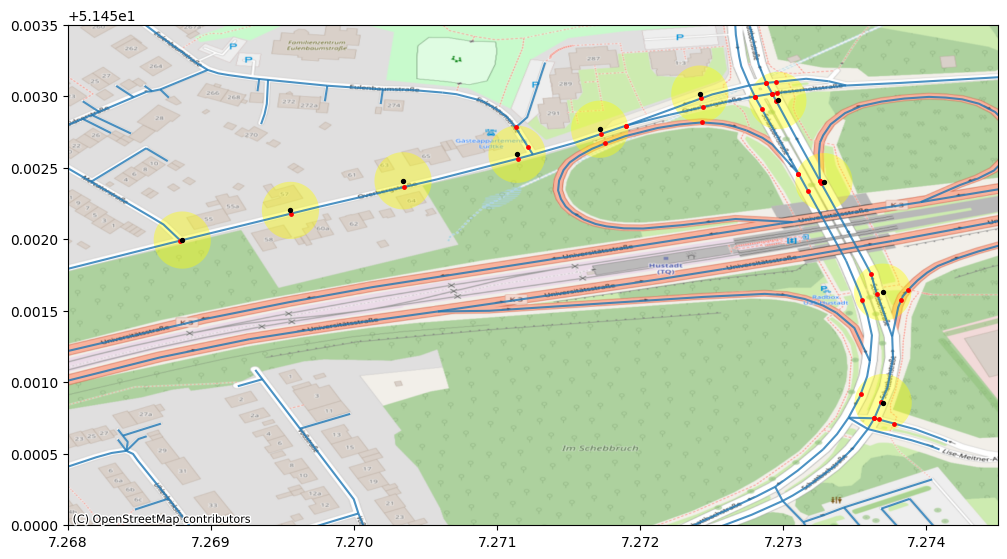

In [71]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.ylim((51.450,51.4535))
plt.xlim((7.268,7.2745))
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
puffergdf.plot(ax=ax, color='yellow', alpha=0.4)
gdfStreets.plot(ax=ax, alpha=0.8)
snappedPointsGdf.plot(ax=ax, color='red', markersize=6, zorder=3)
subCarTracks.plot(ax=ax, color='black', markersize=8, zorder=3)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [72]:
koordinatenSnappedPts = {}
for index, row in snappedPointsGdf.iterrows():
    koordinatenSnappedPts[row['id']] = (row['geometry'].x, row['geometry'].y)
#koordinatenSnappedPts

In [84]:
snappedPtsGraph = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    if lastIndex != -1: #nicht erste iteration
        tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
        for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
            snappedPtsGraph[firstCol['id']] = list(tempPoints['id'])
    lastIndex = puffrow['Id']
snappedPtsGraph

{0: [6, 7, 8, 9, 10],
 1: [6, 7, 8, 9, 10],
 2: [6, 7, 8, 9, 10],
 3: [6, 7, 8, 9, 10],
 4: [6, 7, 8, 9, 10],
 5: [6, 7, 8, 9, 10],
 6: [11, 12, 13, 14, 15, 16],
 7: [11, 12, 13, 14, 15, 16],
 8: [11, 12, 13, 14, 15, 16],
 9: [11, 12, 13, 14, 15, 16],
 10: [11, 12, 13, 14, 15, 16],
 11: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 12: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 13: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 14: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 15: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 16: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 17: [27, 28, 29],
 18: [27, 28, 29],
 19: [27, 28, 29],
 20: [27, 28, 29],
 21: [27, 28, 29],
 22: [27, 28, 29],
 23: [27, 28, 29],
 24: [27, 28, 29],
 25: [27, 28, 29],
 26: [27, 28, 29],
 27: [30, 31, 32, 33],
 28: [30, 31, 32, 33],
 29: [30, 31, 32, 33],
 30: [34, 35, 36],
 31: [34, 35, 36],
 32: [34, 35, 36],
 33: [34, 35, 36],
 34: [37],
 35: [37],
 36: [37],
 37: [38],
 38: [39, 40]}

In [85]:
def getDistances(sourcePs, destPs, metrics = "duration"):
    # bei "duration" antwort in Sekunden
    # dei "distance" antwort in Metern
    url = "https://ors5.fbg-hsbo.de//v2/matrix/driving-car"
    N = len(sourcePs)
    M = len(destPs)
    locationsP = sourcePs + destPs
    body = {"locations":locationsP, "destinations":list(range(N,N+M)), "sources":list(range(0,N)), "metrics":[metrics]}
    # spalten nach destinations, zeile nach sources
    headers = {'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624837b0be5d89604065b03e13c82ba84c06',
    'Content-Type': 'application/json; charset=utf-8'}
    call = requests.post(url, json=body)
    edgeValues = json.loads(call.text)[metrics+"s"]
    return edgeValues

def createForks(sourcePIDs, destPIDs, distMatrix):
    retDict = {}
    for sPID in sourcePIDs:
        retDict[sPID] = {}
    for j in range(0, len(sourcePIDs)):
        sourcePID = sourcePIDs[j]
        for i in range(0, len(destPIDs)):
            #print(i)
            retDict[sourcePID][destPIDs[i]] = distMatrix[j][i]
    return retDict

def createProbGraph(pDict, forkDict, metrics = "duration"):
    #TODO: Kantenwerte als Wahrscheinlichkeioten...
    outputGraph = {}
    for sourcePID, destPIDList in forkDict.items():
        tempDestPDict = {}
        for destPID in destPIDList:
            tempDestPDict[destPID] = pDict[destPID]
            pDict[sourcePID]
            distances = getDistances([pDict[sourcePID]],list(tempDestPDict.values()), metrics = metrics)
            total = sum(distances[0])                         
            ws = []
            for value in distances[0]:
                ws.append(value/total)
            outputGraph.update(createForks([sourcePID],list(tempDestPDict.keys()),[ws]))
            #time.sleep(10)
    return outputGraph

In [75]:
routingGraph = createProbGraph(koordinatenSnappedPts, snappedPtsGraph)

In [86]:
routingGraph

{0: {6: 0.1361992136304063,
  7: 0.14857142857142858,
  8: 0.4348099606815203,
  9: 0.13190039318479685,
  10: 0.14851900393184797},
 1: {6: 0.11421123088846614,
  7: 0.13090960332558302,
  8: 0.515606284788276,
  9: 0.10843373493975904,
  10: 0.13083914605791586},
 2: {6: 0.1080570867628181,
  7: 0.12595333383674392,
  8: 0.5382466208563014,
  9: 0.10186513629842181,
  10: 0.12587782224571473},
 3: {6: 0.11421123088846614,
  7: 0.13090960332558302,
  8: 0.515606284788276,
  9: 0.10843373493975904,
  10: 0.13083914605791586},
 4: {6: 0.115137998327293,
  7: 0.13165597992751604,
  8: 0.5121968218567048,
  9: 0.10942291608586563,
  10: 0.13158628380262058},
 5: {6: 0.11854428686111852,
  7: 0.13439925073588438,
  8: 0.49966550709124957,
  9: 0.11305860315761304,
  10: 0.1343323521541343},
 6: {11: 0.15235256754775983,
  12: 0.18262569013533983,
  13: 0.18043680070357163,
  14: 0.15179557336199737,
  15: 0.15235256754775983,
  16: 0.18043680070357163},
 7: {11: 0.07276573919733298,
  12: 

In [87]:
distanceGraph = {}
distanceGraph[-1] = {}
for index, node in snappedPointsGdf.iterrows():
    distanceGraph[node['id']] = {}
lastIndex = -1
for index, puffrow in puffergdf.iterrows():
    tempPoints = snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffrow['Id']]
    summe = 0
    for index, tp1 in tempPoints.iterrows():
        actSnappedPoint = (tp1['geometry'].x, tp1['geometry'].y)
        actBasePoint = (subCarTracks['geometry'].iloc[puffrow['Id']-1].x, subCarTracks['geometry'].iloc[puffrow['Id']-1].y)
        abstand = distance.euclidean(actSnappedPoint, actBasePoint)
        summe = summe + abstand
    if lastIndex == -1:
        for index, tp in tempPoints.iterrows():
            actSnappedPoint = (tp['geometry'].x, tp['geometry'].y)
            actBasePoint = (subCarTracks['geometry'].iloc[puffrow['Id']-1].x, subCarTracks['geometry'].iloc[puffrow['Id']-1].y)
            abstand = distance.euclidean(actSnappedPoint, actBasePoint)
            distanceGraph[-1][tp['id']] = (abstand/summe)
    else:
        for i, secondCol in tempPoints.iterrows():
            for j, firstCol in (snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == lastIndex]).iterrows():
                actBasePoint = (subCarTracks['geometry'].iloc[puffrow['Id']-1].x, subCarTracks['geometry'].iloc[puffrow['Id']-1].y)
                secColPoint = (secondCol['geometry'].x, secondCol['geometry'].y)
                abstand = distance.euclidean(actBasePoint, secColPoint)
                distanceGraph[firstCol['id']][secondCol['id']] = ((abstand/summe)) * routingGraph[firstCol['id']][secondCol['id']]
    lastIndex = puffrow['Id']
for index, pts in snappedPointsGdf.loc[snappedPointsGdf['pufferId'] == puffergdf['Id'].max()].iterrows():
    distanceGraph[pts['id']][-2] = 0

In [88]:
unbesuchteKnoten = list(distanceGraph)
unbesuchteKnoten.append(-2)
dijkstraTable = pd.DataFrame(unbesuchteKnoten, columns=['Knoten'])
dijkstraTable['Vorgaenger'] = -99
dijkstraTable['Gesamtdistanz'] = float('inf')
startID = -1
endID = -2

dijkstraTable.loc[dijkstraTable['Knoten'] == -1,'Gesamtdistanz'] = 0
for nachbarn in distanceGraph[startID].items():
    dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Gesamtdistanz'] = nachbarn[1]
    dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Vorgaenger'] = -1
unbesuchteKnoten.remove(-1)
while (len(unbesuchteKnoten) != 0 and (-2 in unbesuchteKnoten)):
    tempTabelle = dijkstraTable[dijkstraTable['Vorgaenger'] != -99]
    tempTabelle.sort_values(by=['Gesamtdistanz'], inplace=True)
    i =0
    while(tempTabelle.iloc[i]['Knoten'] not in unbesuchteKnoten):
        i = i+1
    activePoint = tempTabelle.iloc[i]
    if (activePoint['Knoten'] != -2):
        for nachbarn in distanceGraph[activePoint['Knoten']].items():
            if nachbarn[0] in unbesuchteKnoten:
                if ((activePoint['Gesamtdistanz']+nachbarn[1]) < dijkstraTable[dijkstraTable['Knoten'] == nachbarn[0]]['Gesamtdistanz']).bool():
                    dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Gesamtdistanz'] = activePoint['Gesamtdistanz']+nachbarn[1]
                    dijkstraTable.loc[dijkstraTable['Knoten'] == nachbarn[0],'Vorgaenger'] = activePoint['Knoten']
            dijkstraTable
    unbesuchteKnoten.remove(activePoint['Knoten'])
#dijkstraTable

C:\Users\Admin\AppData\Local\Temp\ipykernel_17012\3221849239.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempTabelle.sort_values(by=['Gesamtdistanz'], inplace=True)


In [89]:
fahrtwegIds = [-2]
while ((dijkstraTable[dijkstraTable["Knoten"] == fahrtwegIds[-1]]["Vorgaenger"]).item() != -99):
    fahrtwegIds.append(dijkstraTable[dijkstraTable["Knoten"] == fahrtwegIds[-1]]["Vorgaenger"].item())
fahrtwegIds.reverse()
fahrtwegIds.remove(-1)
fahrtwegIds.remove(-2)
fahrtwegIds

[2, 9, 14, 17, 28, 31, 34, 37, 38, 40]

In [90]:
fahrtwegCoords = []
for id in fahrtwegIds:
    fahrtwegCoords.append([koordinatenSnappedPts[id][0], koordinatenSnappedPts[id][1]])
fahrtwegCoords

[[7.2736851472366695, 51.45086302123814],
 [7.273655456747112, 51.45161523811082],
 [7.2732644306868295, 51.45239099087379],
 [7.272951092887864, 51.45296327985172],
 [7.272426716195182, 51.45298369246032],
 [7.271727299591063, 51.45273548378866],
 [7.271146867623291, 51.45256321363214],
 [7.270351901134425, 51.45236483875899],
 [7.26956021881448, 51.452178681312695],
 [7.268798949556759, 51.4519930423438]]

In [91]:
shortestSnappedPts = []
for row in fahrtwegIds:
    shortestSnappedPts.append({
        'id': row,
        'geometry': Point(koordinatenSnappedPts[row][0], koordinatenSnappedPts[row][1])
     })
    i = i+1
shortestSnappedPtsGDF = gp.GeoDataFrame(shortestSnappedPts)
shortestSnappedPtsGDF

,id,geometry
0,2,POINT (7.27369 51.45086)
1,9,POINT (7.27366 51.45162)
2,14,POINT (7.27326 51.45239)
3,17,POINT (7.27295 51.45296)
4,28,POINT (7.27243 51.45298)
5,31,POINT (7.27173 51.45274)
6,34,POINT (7.27115 51.45256)
7,37,POINT (7.27035 51.45236)
8,38,POINT (7.26956 51.45218)
9,40,POINT (7.26880 51.45199)


In [92]:
body = {"coordinates":fahrtwegCoords}
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624837b0be5d89604065b03e13c82ba84c06',
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post('https://api.openrouteservice.org/v2/directions/driving-car/geojson', json=body, headers=headers)
fahrtwegLine = json.loads(call.text)["features"][0]["geometry"]
print(fahrtwegLine)

{'coordinates': [[7.273685, 51.450863], [7.273729, 51.450965], [7.273766, 51.451166], [7.273761, 51.451319], [7.273683, 51.451538], [7.273655, 51.451615], [7.273643, 51.451651], [7.273614, 51.451756], [7.273554, 51.451868], [7.273322, 51.452288], [7.273264, 51.452391], [7.273257, 51.452404], [7.273075, 51.452733], [7.272951, 51.452963], [7.272922, 51.453017], [7.272881, 51.453092], [7.272763, 51.453074], [7.272585, 51.453031], [7.272431, 51.452978], [7.272056, 51.452849], [7.271899, 51.452792], [7.271735, 51.452738], [7.271727, 51.452735], [7.271541, 51.452673], [7.27125, 51.452591], [7.271147, 51.452563], [7.271116, 51.452555], [7.270349, 51.452369], [7.269561, 51.452178], [7.269084, 51.452063], [7.268799, 51.451993]], 'type': 'LineString'}


In [93]:
geom = [shape(i) for i in [fahrtwegLine]]
fahrtwegGDF = gp.GeoDataFrame({'geometry':geom})
fahrtwegGDF

,geometry
0,"LINESTRING (7.27369 51.45086, 7.27373 51.45096..."


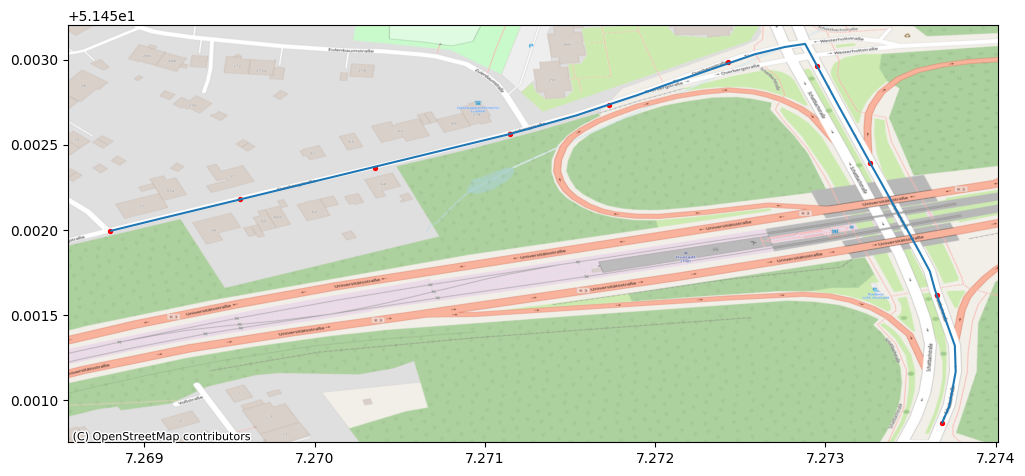

In [94]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = shortestSnappedPtsGDF.plot(ax=fahrtwegGDF.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)

In [95]:
tmp_list = []
for x in range(0,myCarTrack.shape[0],1):
    tmp_list.append({
      'id': myCarTrack.loc[x,'id'],
      'time': myCarTrack.loc[x,'time'],
      'phenomenons': myCarTrack.loc[x,'phenomenons'],
      'geometry': myCarTrack.loc[x,'geometry']
     })
allCarPoints = gp.GeoDataFrame(tmp_list)
#allCarPoints

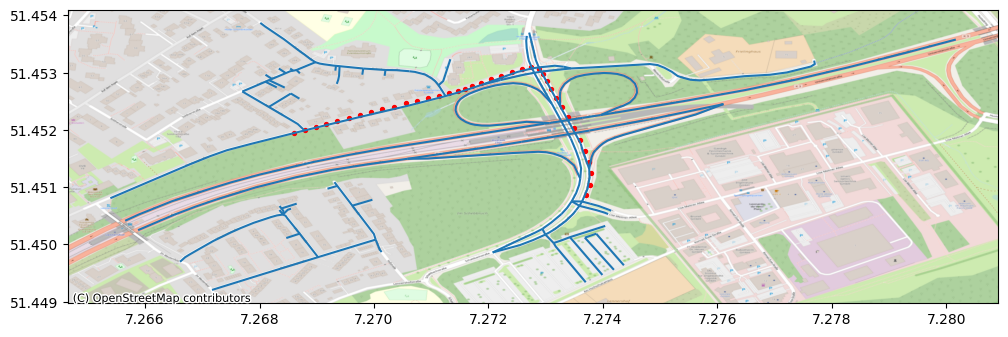

In [96]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#worldMap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
ax = allCarPoints.plot(ax=gdfStreets.plot(), color='red', markersize=8)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=4326)